# Bibliotecas/Pacotes

In [0]:
import pandas as pd

import numpy as np

from sklearn import preprocessing

import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

import branca.colormap as cmap

import folium

import seaborn

# Leitura do Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv("/content/drive/My Drive/MD/dataset/Crimes_-_2014_to_present .csv", error_bad_lines=False)
print(data.shape)
data.head()

(1576883, 22)


ID Case Number                    Date  ... Latitude Longitude Location
0  11885005    JC498665  01/01/2014 12:00:00 AM  ...      NaN       NaN      NaN
1  11835107    JC441223  01/01/2014 12:00:00 AM  ...      NaN       NaN      NaN
2  11831695    JC437127  01/01/2014 12:00:00 AM  ...      NaN       NaN      NaN
3  11403889    JB380328  01/01/2014 12:00:00 AM  ...      NaN       NaN      NaN
4  11729541    JC314736  01/01/2014 12:00:00 AM  ...      NaN       NaN      NaN

[5 rows x 22 columns]

# Pré-Processamento

In [0]:
#Exclusão de colunas redundantes
data.drop(['X Coordinate', 'Y Coordinate', 'Updated On', 'Location', 'Beat'], axis=1, inplace=True)

#Exclusão de dados com valores faltantes
data = data.dropna()
 
#Exclusão de dados duplicados
data = data.drop_duplicates()

#Criação de novas features
data['Date'] = pd.to_datetime(data['Date'] ,dayfirst=True)
data['Weekday'] = data['Date'].dt.day_name()
data['Week Number'] = data['Date'].dt.week
data['Weekend'] = [ w in ['Saturday','Sunday'] for w in data['Weekday'] ]
data['Time'] = [d.time() for d in data['Date']]
data['Date'] = [d.date() for d in data['Date']]

def toSeconds( t ):
  return (t.hour*60*60) + (t.minute*60) + t.second

data['Seconds'] = [ toSeconds(t) for t in data['Time'] ]
data['Hours'] = [ t.hour for t in data['Time'] ]

print(data.shape)
data.head()

(1554692, 23)


ID Case Number        Date  ...      Time Seconds Hours
47  10098334    HY286515  2014-01-01  ...  00:00:00       0     0
48  10196111    HY383441  2014-01-01  ...  00:00:00       0     0
49  10199744    HY387412  2014-01-01  ...  00:00:00       0     0
50  10218900    HY405604  2014-01-01  ...  00:00:00       0     0
51  10222575    HY409193  2014-01-01  ...  00:00:00       0     0

[5 rows x 23 columns]

# Análise Exploratória ( Visão Geral )

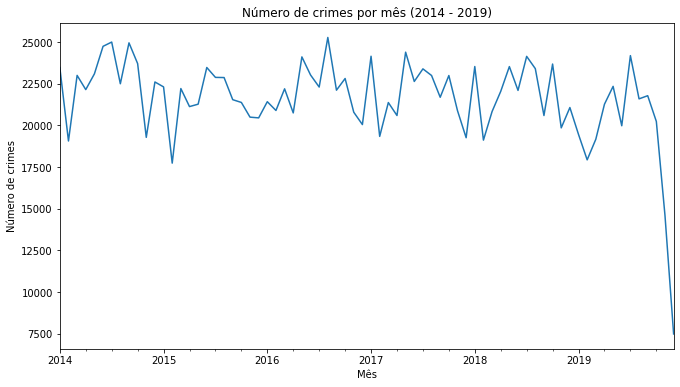

In [0]:
data.index = pd.DatetimeIndex(data.Date)

plt.figure(figsize=(11,6))
data.resample('BM').size().plot(legend=False)
plt.title('Número de crimes por mês (2014 - 2019)')
plt.xlabel('Mês')
plt.ylabel('Número de crimes')
plt.show()

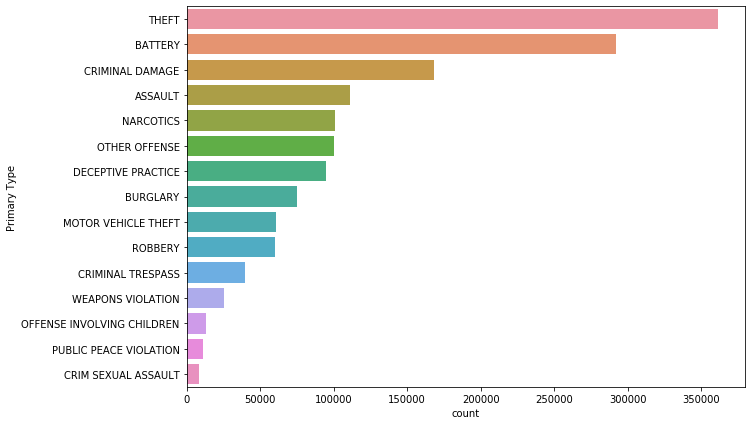

In [0]:
fig = plt.figure( figsize=(10,7) )
seaborn.countplot(y= 'Primary Type', data = data, order = data['Primary Type'].value_counts().keys()[:15] )

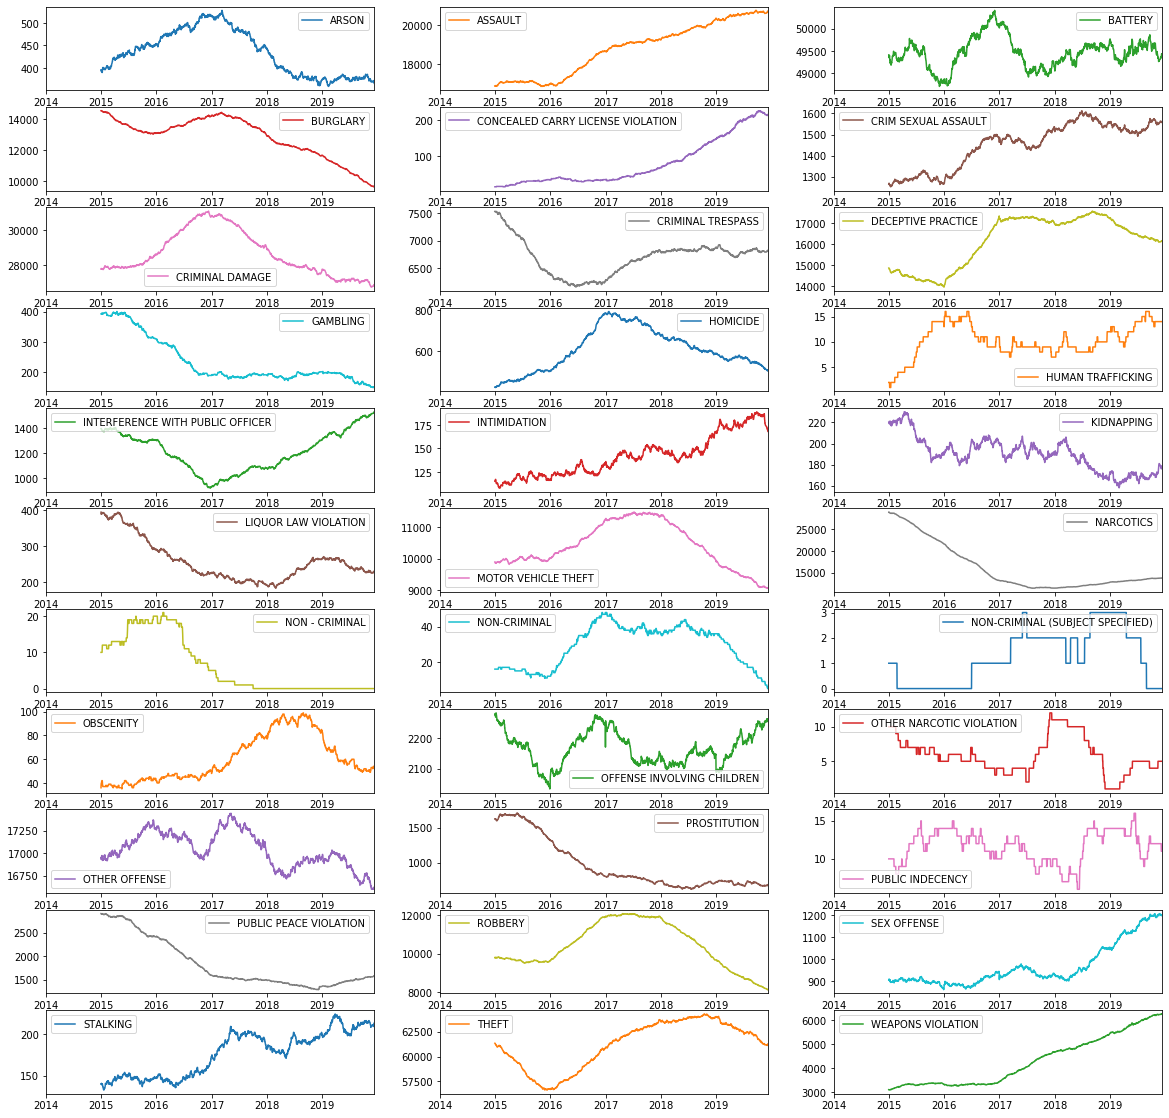

In [0]:
crimes_date = data.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=data.index.date, fill_value=0)

crimes_date.index = pd.DatetimeIndex(crimes_date.index)

plo = crimes_date.rolling(365).sum().plot(figsize=(20, 20), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

In [0]:
plo

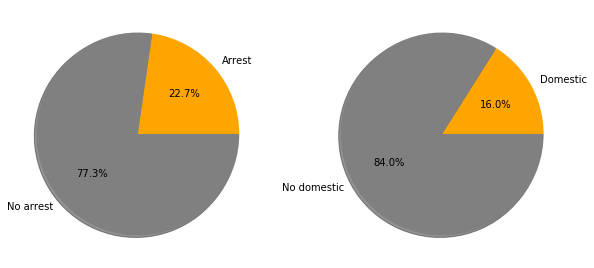

In [0]:
fig = plt.figure( figsize=(10,7) )

aux = [ data[ data['Arrest'] == True ].shape[0], data[ data['Arrest'] == False ].shape[0] ]

plt.subplot(121)

plt.pie(aux, labels=['Arrest','No arrest'],autopct='%1.1f%%',shadow=True,colors=['orange','gray'])

aux = [ data[ data['Domestic'] == True ].shape[0], data[ data['Domestic'] == False ].shape[0] ]

plt.subplot(122)

plt.pie(aux, labels=['Domestic','No domestic'],autopct='%1.1f%%',shadow=True,colors=['orange','gray'])

plt.show()

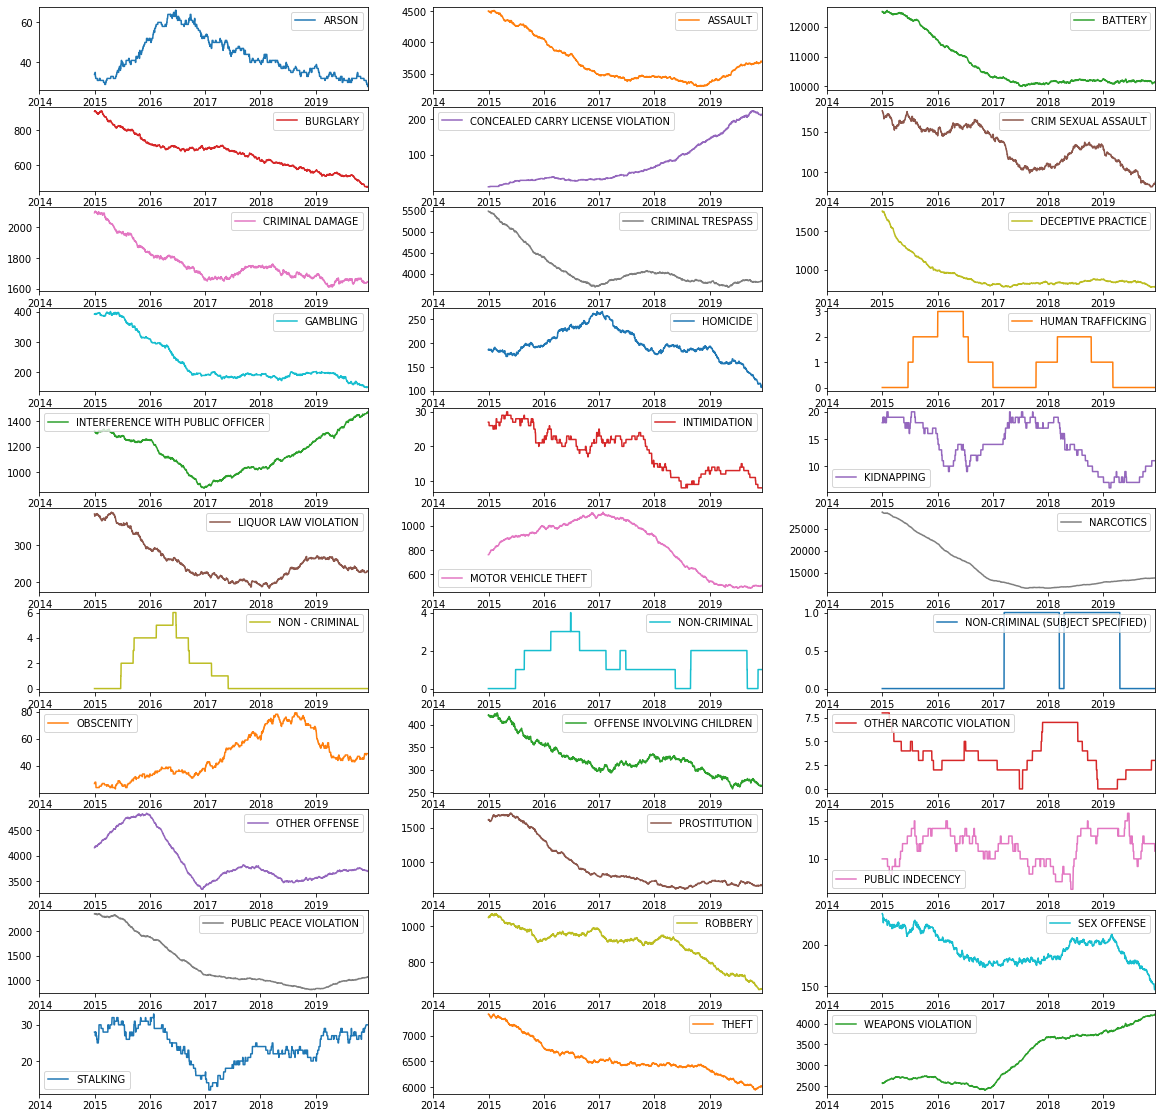

In [0]:
dataArrest = data[ data['Arrest'] == True ]
dataArrest.index = pd.DatetimeIndex(dataArrest.Date)

crimes_date_arrest = dataArrest.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=dataArrest.index.date, fill_value=0)

crimes_date_arrest.index = pd.DatetimeIndex(crimes_date.index)

plo = crimes_date_arrest.rolling(365).sum().plot(figsize=(20, 20), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

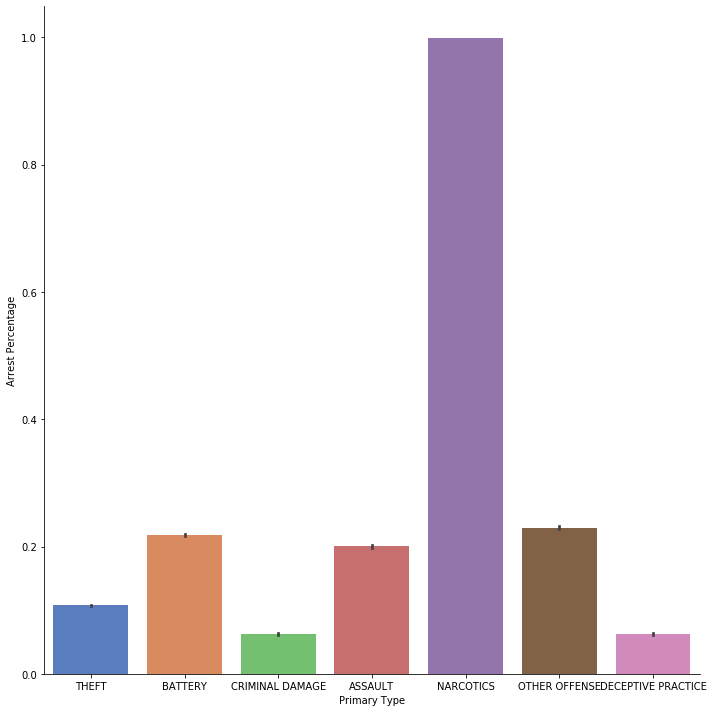

In [0]:
s = seaborn.catplot(x="Primary Type", y="Arrest", data=data
                ,kind="bar", palette="muted", height=10
                ,order = data['Primary Type'].value_counts().keys()[:7] )
s.set_ylabels("Arrest Percentage")

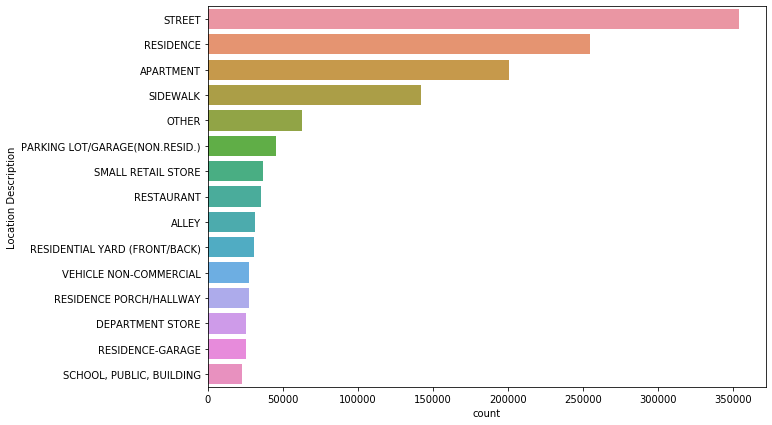

In [0]:
fig = plt.figure( figsize=(10,7) )

seaborn.countplot(y= 'Location Description', data = data, 
                  order = data['Location Description'].value_counts().keys()[:15] )

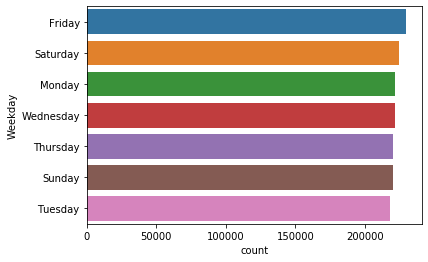

In [0]:
seaborn.countplot(y= 'Weekday', data = data, 
                  order = data['Weekday'].value_counts().keys() )

# Análise Exploratória ( Mapa )

In [0]:
data_plot_mapa = data.sample(2900,random_state=40 )

In [0]:
mapa = folium.Map(location=[41.8379,-87.6828], tiles='CartoDB dark_matter',zoom_start=11)

for (la,lo) in zip( data_plot_mapa['Latitude'].values, data_plot_mapa['Longitude'].values  ):
    
    folium.CircleMarker(location = [la,lo], fill = True,
                        radius=2, color='red').add_to(mapa)

mapa

In [0]:
mapa_district = folium.Map(location=[41.8379,-87.6828], tiles='CartoDB dark_matter',zoom_start=11)

#Contando a quantidade de registros de cada distrito
q = {}
for d in range(40):
    q[d] = (data[ data['District'] == d ].shape[0])

In [0]:
colormap = cmap.linear.YlOrRd_09.scale( min(q.values()), max(q.values()) )
colormap

In [0]:
#Adicionando ao mapa a divisão dos distritos

import json
distritos = '/content/drive/My Drive/MD/geojson/chicago_police_districts.geojson'
geo_json_data = json.load(open(distritos))

folium.GeoJson(
    geo_json_data,
    style_function=lambda f: {
        'fillColor': colormap(q[ int(f['properties']['dist_num']) ]),
        'color': 'green',
        'weight': 1,
        #'dashArray': '5, 5'
    }
    
).add_to(mapa_district)

In [0]:
for d in np.sort( data['District'].unique() ):
    la = data[ data['District'] == d ]['Latitude'].mean()
    lo = data[ data['District'] == d ]['Longitude'].mean()
    arrest = (data[ data['District'] == d  ][ 'Arrest'].sum())/(data[ data['District'] == d  ].shape[0])
    popup_text = """<strong>District: </strong> {}, </br>
                    <strong>Total Crimes: </strong> {}, </br>
                    <Strong>Arrest Percent: </strong> {}%
                 """
    popup_text = popup_text.format(d,q[d],arrest*100)
    folium.CircleMarker(location = [la,lo], popup= popup_text, fill = True,
                        radius=10, color='white',tooltip=("District " + str(d)) ).add_to(mapa_district)

In [0]:
colormap.add_to(mapa_district)

mapa_district

In [0]:
mask = (data['Primary Type']=='NARCOTICS') | (data['Primary Type']=='ASSAULT') | (data['Primary Type']=='HOMICIDE') | (data['Primary Type']=='CRIM SEXUAL ASSAULT') | (data['Primary Type']=='SEX OFFENSE') | (data['Primary Type']=='STALKING')|(data['Primary Type']=='WEAPONS VIOLATION')|(data['Primary Type']=='BATTERY') | (data['Primary Type']=='PUBLIC PEACE VIOLATION') | (data['Primary Type']=='MOTOR VEHICLE THEFT')
data_main_crimes = data[mask]
print(data_main_crimes.shape)
print(data_main_crimes['Primary Type'].value_counts())

(619786, 23)
BATTERY                   292037
ASSAULT                   110889
NARCOTICS                 100639
MOTOR VEHICLE THEFT        60495
WEAPONS VIOLATION          25706
PUBLIC PEACE VIOLATION     11195
CRIM SEXUAL ASSAULT         8531
SEX OFFENSE                 5815
HOMICIDE                    3441
STALKING                    1038
Name: Primary Type, dtype: int64


# Clusterização

In [0]:
sub_data0 = data_main_crimes.loc[:,['Latitude', 'Longitude', 'Week Number','Seconds']]

scaler = preprocessing.StandardScaler()

sub_data0[sub_data0.columns] = scaler.fit_transform(sub_data0)
sub_data0.head()

Latitude  Longitude  Week Number   Seconds
47 -0.315124   0.081721    -1.721879 -2.041096
54 -0.534858  -0.507632    -1.721879 -2.041096
56 -0.574393  -0.206976    -1.721879 -2.041096
62  0.446272  -1.166915    -1.721879 -2.041096
63  0.294479  -0.999907    -1.721879 -2.041096

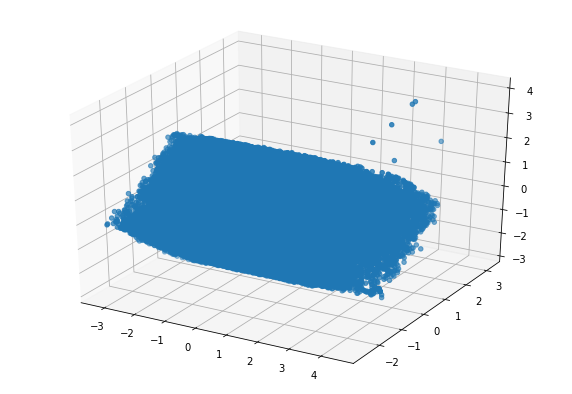

In [0]:
pc = PCA(3)
sub_data0_= pc.fit_transform(sub_data0)

fig = plt.figure( figsize=(10,7) )
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xs=sub_data0_[:,0] ,ys=sub_data0_[:,1], zs=sub_data0_[:,2])
plt.show()

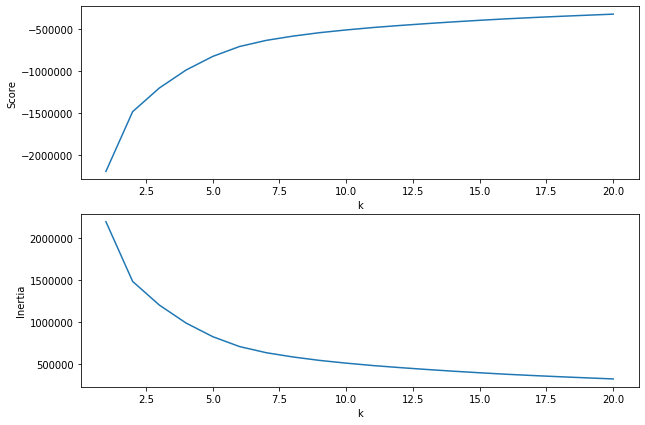

In [0]:
scores = np.zeros(20)
inertias = np.zeros(20)
for k in range(20):
  model = KMeans(n_clusters=k+1)
  model.fit(sub_data0_)
  scores[k] = model.score(sub_data0_)
  inertias[k] = model.inertia_


fig = plt.figure( figsize=(10,7) )

plt.subplot(211)

plt.plot( range(1,21), scores  )
plt.xlabel("k")
plt.ylabel("Score")

plt.subplot(212)

plt.plot( range(1,21), inertias )
plt.xlabel("k")
plt.ylabel("Inertia")

plt.show()

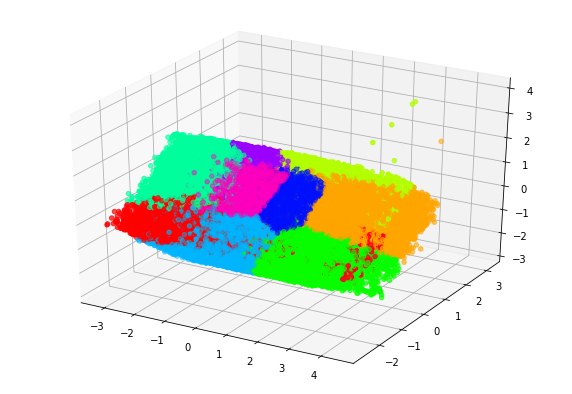

In [0]:
model = KMeans(n_clusters=10)
model.fit(sub_data0_)

fig = plt.figure( figsize=(10,7) )
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xs=sub_data0_[:,0] ,ys=sub_data0_[:,1], zs=sub_data0_[:,2], c=model.labels_, cmap='hsv' )
plt.show()

In [0]:
sub_data0['Cluster'] = model.labels_

sub_data0.head()

Latitude  Longitude  Week Number   Seconds  Cluster
47 -0.315124   0.081721    -1.721879 -2.041096        0
54 -0.534858  -0.507632    -1.721879 -2.041096        0
56 -0.574393  -0.206976    -1.721879 -2.041096        0
62  0.446272  -1.166915    -1.721879 -2.041096        9
63  0.294479  -0.999907    -1.721879 -2.041096        9

## Análise de Cluster

In [0]:
data0_Cluster_0 = sub_data0[ sub_data0['Cluster'] == 0 ]
data0_Cluster_1 = sub_data0[ sub_data0['Cluster'] == 1 ]
data0_Cluster_2 = sub_data0[ sub_data0['Cluster'] == 2 ]
data0_Cluster_3 = sub_data0[ sub_data0['Cluster'] == 3 ]
data0_Cluster_4 = sub_data0[ sub_data0['Cluster'] == 4 ]
data0_Cluster_5 = sub_data0[ sub_data0['Cluster'] == 5 ]
data0_Cluster_6 = sub_data0[ sub_data0['Cluster'] == 6 ]
data0_Cluster_7 = sub_data0[ sub_data0['Cluster'] == 7 ]
data0_Cluster_8 = sub_data0[ sub_data0['Cluster'] == 8 ]
data0_Cluster_9 = sub_data0[ sub_data0['Cluster'] == 9 ]

In [0]:
def plot_hmap(df, xs, ix=None):
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap='Reds')
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]),xs)
    plt.grid(False)

### Cluster0

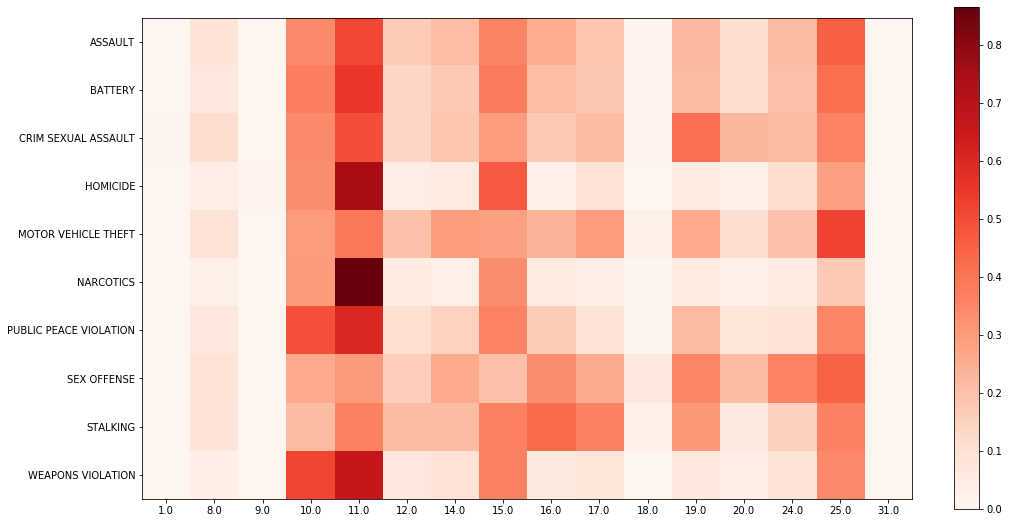

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C0 = data0_Cluster_0.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C0[crime_by_district_C0.columns] = normalize.fit_transform(crime_by_district_C0)

crime_by_hour_C0 = data0_Cluster_0.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C0[crime_by_hour_C0.columns] = normalize.fit_transform(crime_by_hour_C0)

crime_by_week_C0 = data0_Cluster_0.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C0[crime_by_week_C0.columns] = normalize.fit_transform(crime_by_week_C0)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C0, crime_by_district_C0.columns)
plt.show()

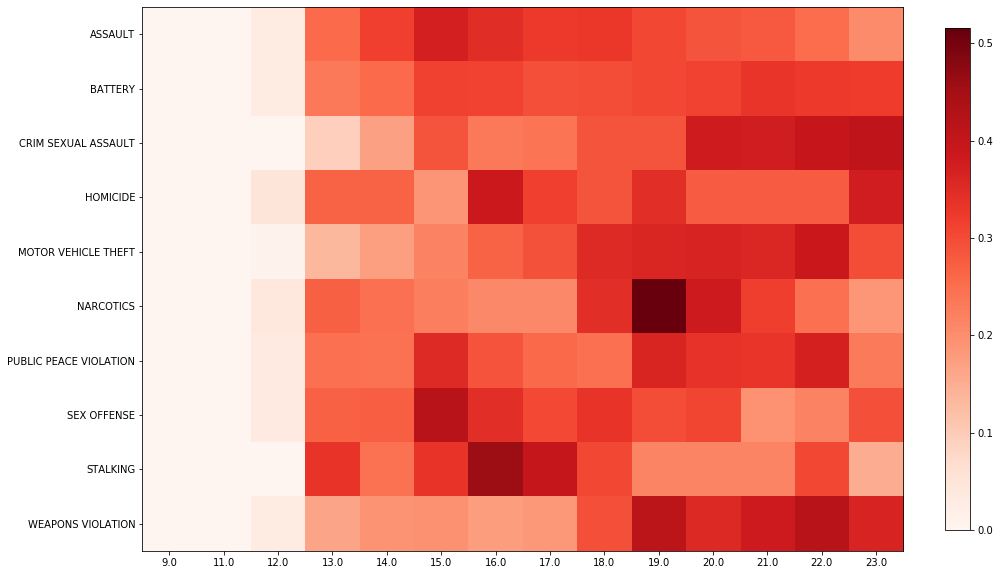

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C0, crime_by_hour_C0.columns)

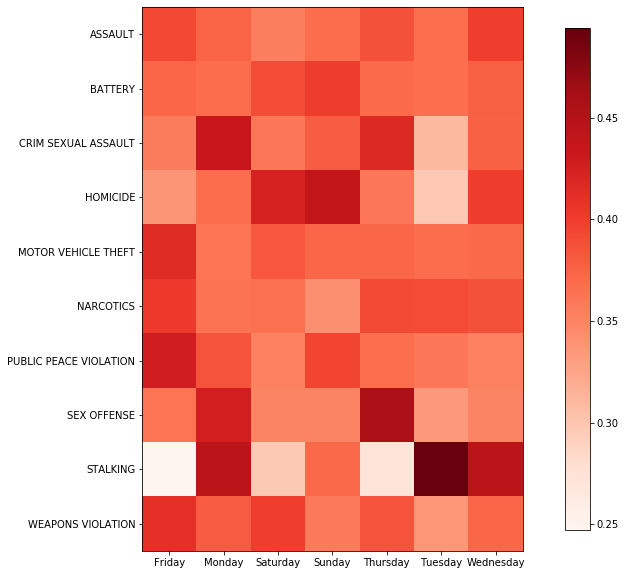

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C0, crime_by_week_C0.columns)

### Cluster1

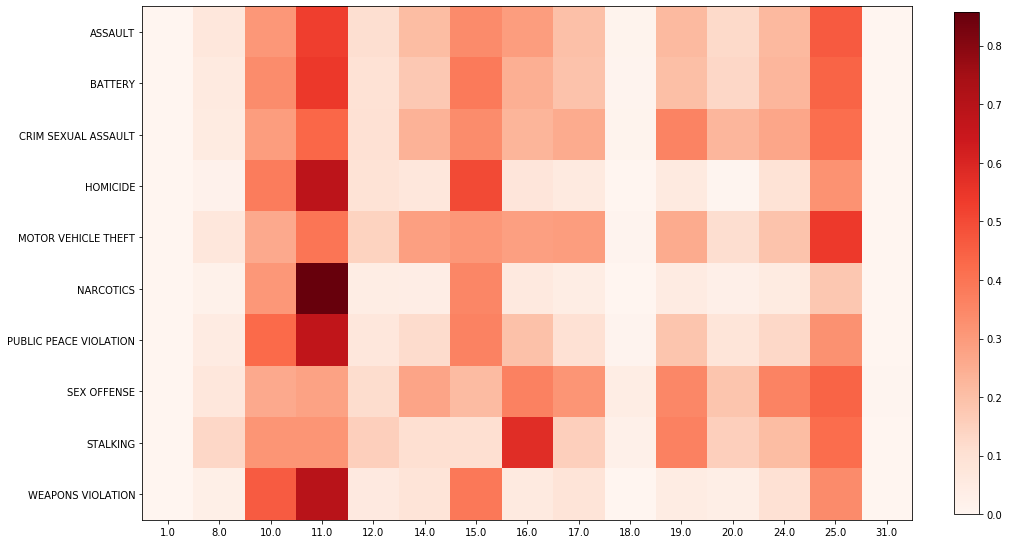

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C1 = data0_Cluster_1.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C1[crime_by_district_C1.columns] = normalize.fit_transform(crime_by_district_C1)

crime_by_hour_C1 = data0_Cluster_1.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C1[crime_by_hour_C1.columns] = normalize.fit_transform(crime_by_hour_C1)

crime_by_week_C1 = data0_Cluster_1.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C1[crime_by_week_C1.columns] = normalize.fit_transform(crime_by_week_C1)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C1, crime_by_district_C1.columns)
plt.show()

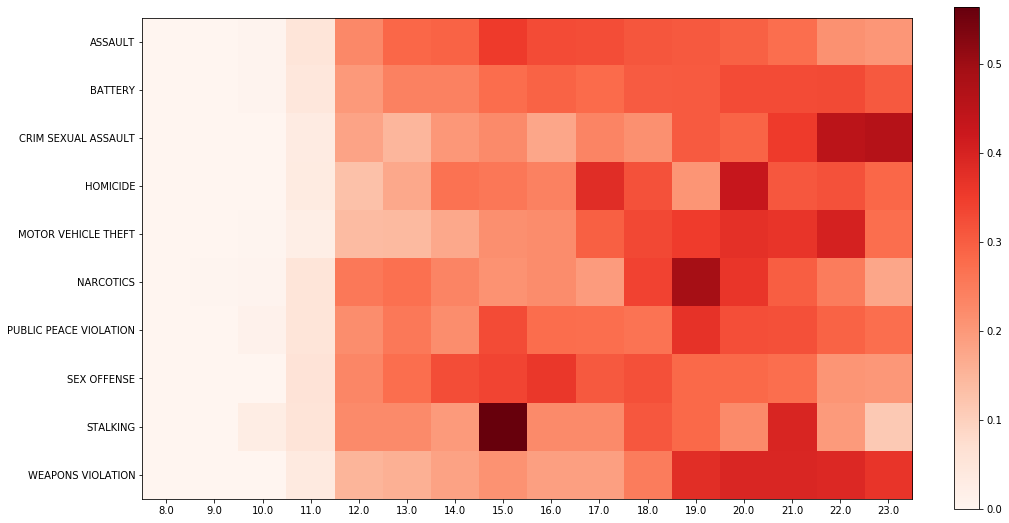

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C1, crime_by_hour_C1.columns)

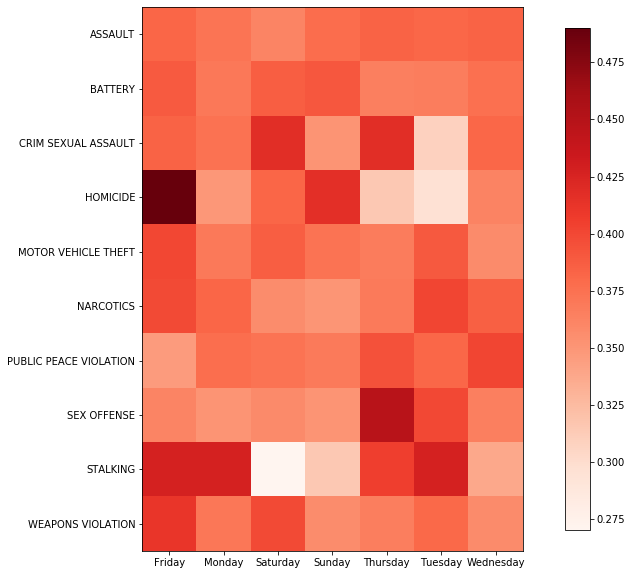

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C1, crime_by_week_C1.columns)

### Cluster2

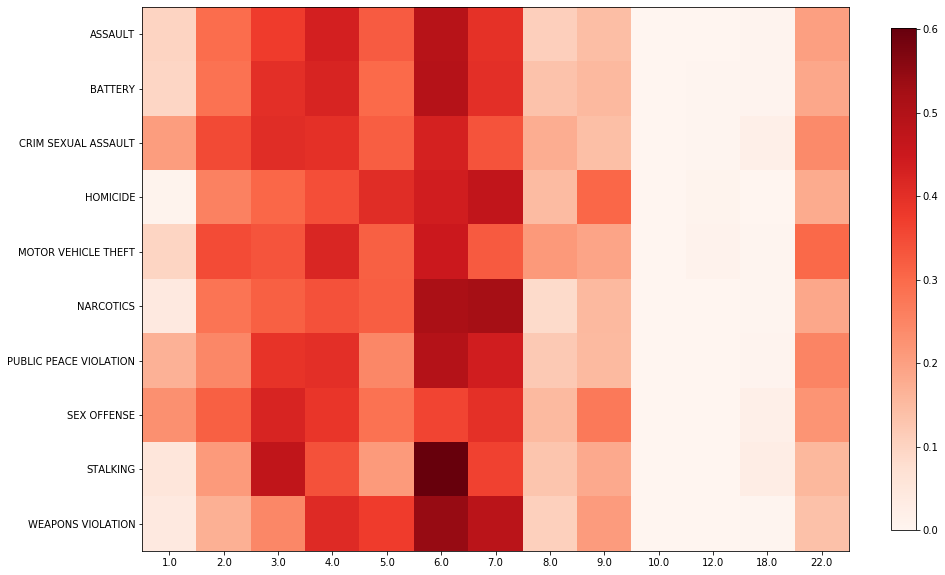

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C2 = data0_Cluster_2.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C2[crime_by_district_C2.columns] = normalize.fit_transform(crime_by_district_C2)

crime_by_hour_C2 = data0_Cluster_2.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C2[crime_by_hour_C2.columns] = normalize.fit_transform(crime_by_hour_C2)

crime_by_week_C2 = data0_Cluster_2.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C2[crime_by_week_C2.columns] = normalize.fit_transform(crime_by_week_C2)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C2, crime_by_district_C2.columns)
plt.show()

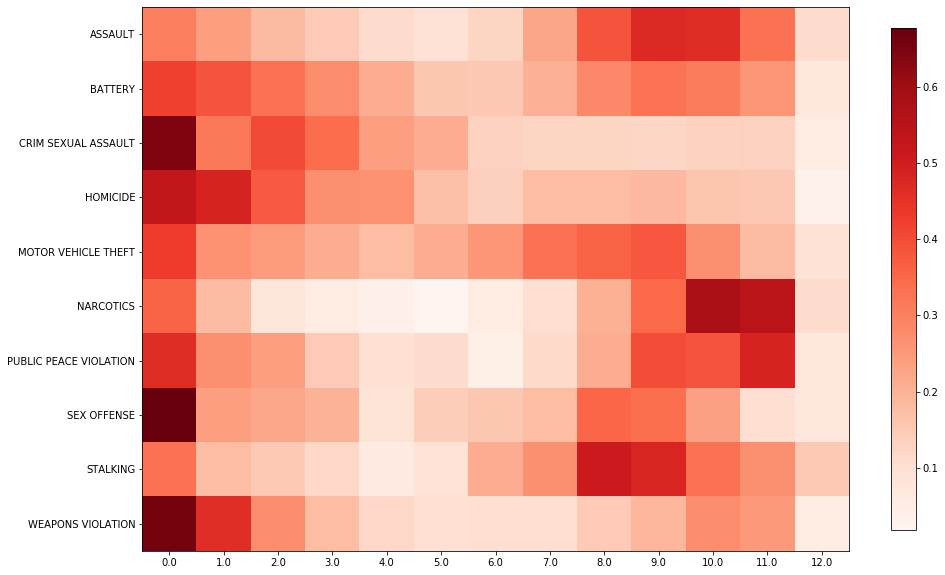

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C2, crime_by_hour_C2.columns)

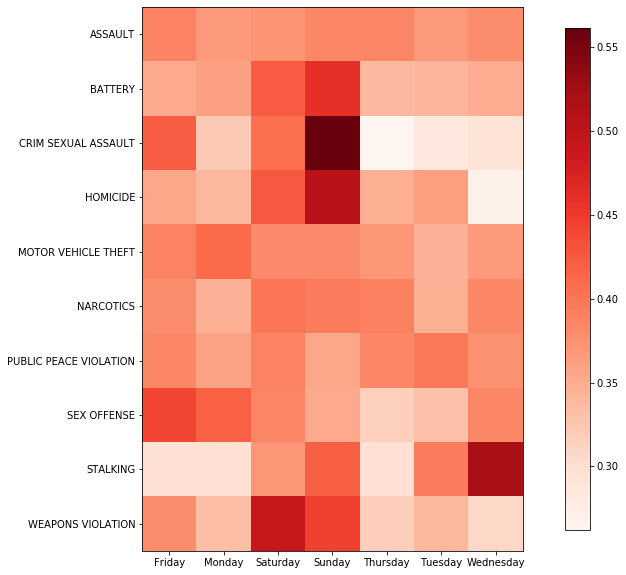

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C2, crime_by_week_C2.columns)

### Cluster3

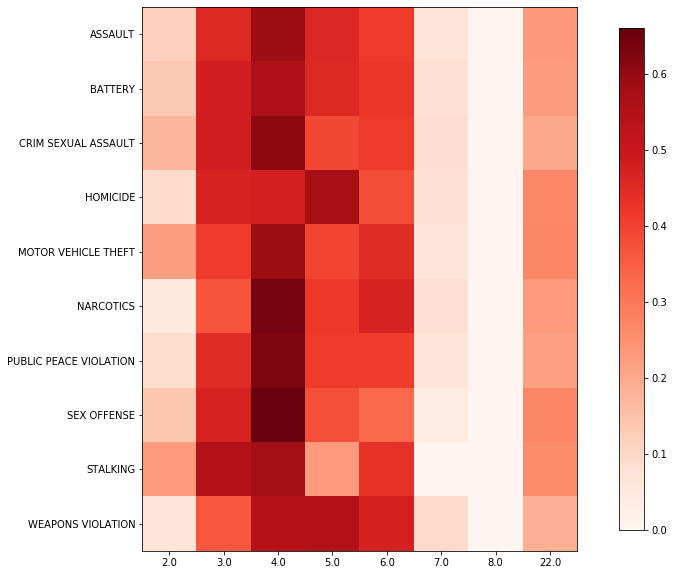

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C3 = data0_Cluster_3.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C3[crime_by_district_C3.columns] = normalize.fit_transform(crime_by_district_C3)

crime_by_hour_C3 = data0_Cluster_3.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C3[crime_by_hour_C3.columns] = normalize.fit_transform(crime_by_hour_C3)

crime_by_week_C3 = data0_Cluster_3.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C3[crime_by_week_C3.columns] = normalize.fit_transform(crime_by_week_C3)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C3, crime_by_district_C3.columns)
plt.show()

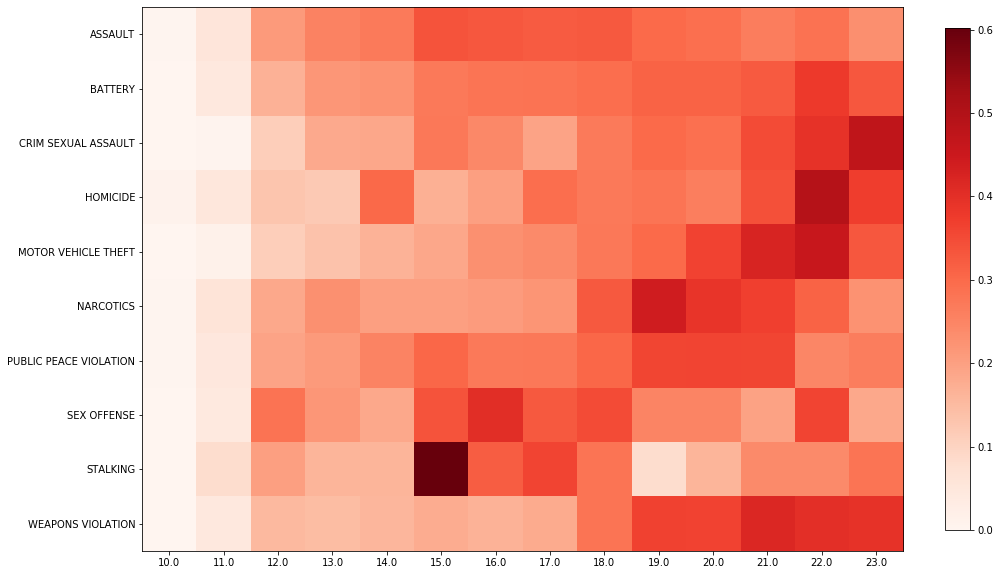

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C3, crime_by_hour_C3.columns)

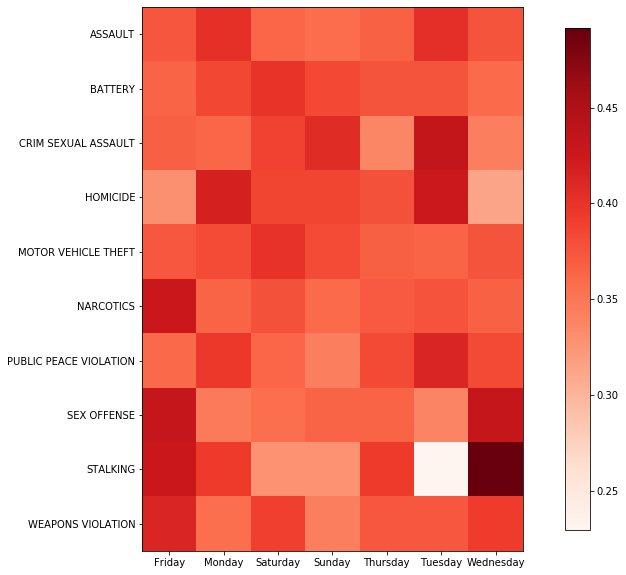

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C3, crime_by_week_C3.columns)

### Cluster4

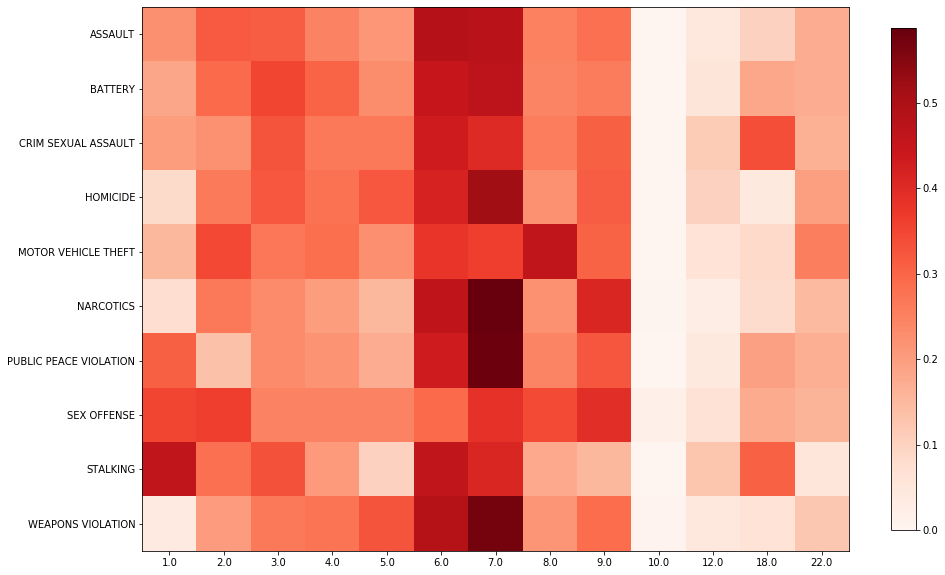

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C4 = data0_Cluster_4.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C4[crime_by_district_C4.columns] = normalize.fit_transform(crime_by_district_C4)

crime_by_hour_C4 = data0_Cluster_4.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C4[crime_by_hour_C4.columns] = normalize.fit_transform(crime_by_hour_C4)

crime_by_week_C4 = data0_Cluster_4.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C4[crime_by_week_C4.columns] = normalize.fit_transform(crime_by_week_C4)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C4, crime_by_district_C4.columns)
plt.show()

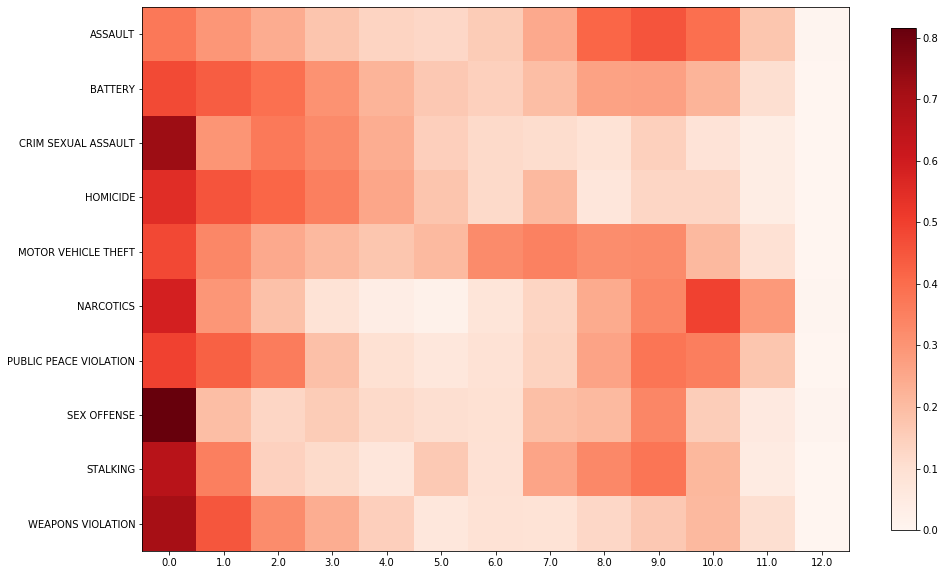

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C4, crime_by_hour_C4.columns)

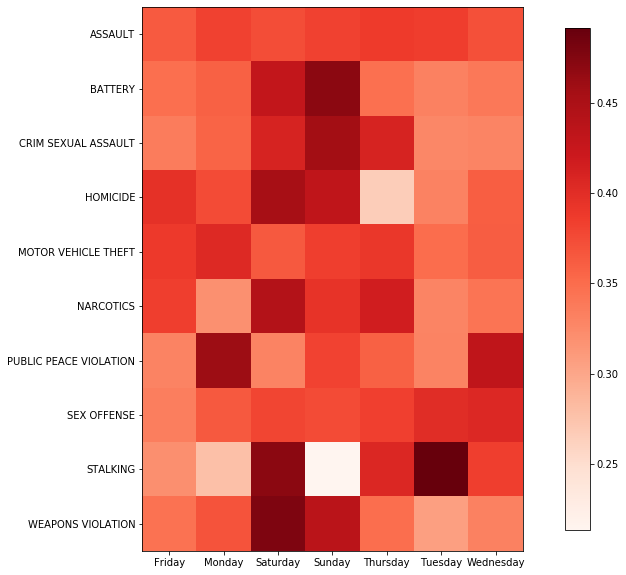

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C4, crime_by_week_C4.columns)

### Cluste 5

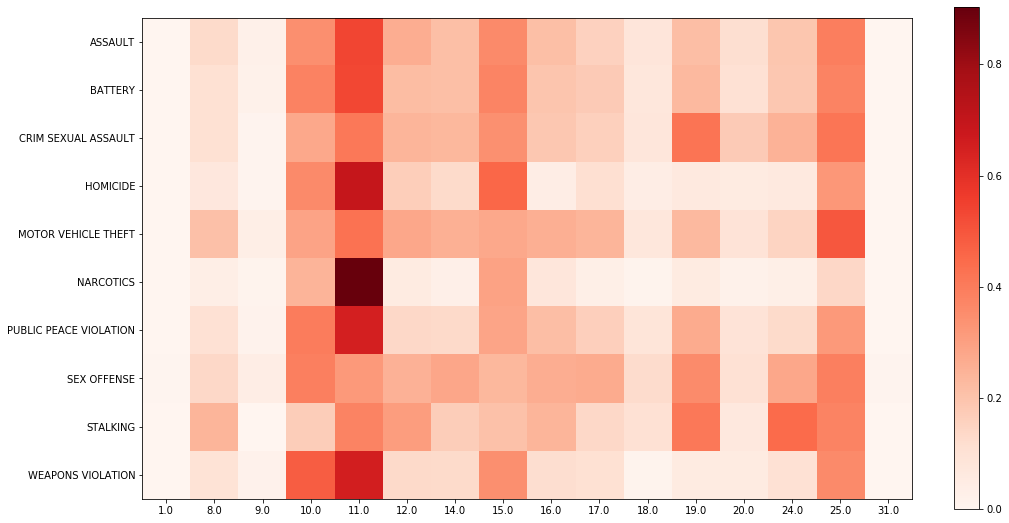

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C5 = data0_Cluster_5.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C5[crime_by_district_C5.columns] = normalize.fit_transform(crime_by_district_C5)

crime_by_hour_C5 = data0_Cluster_5.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C5[crime_by_hour_C5.columns] = normalize.fit_transform(crime_by_hour_C5)

crime_by_week_C5 = data0_Cluster_5.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C5[crime_by_week_C5.columns] = normalize.fit_transform(crime_by_week_C5)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C5, crime_by_district_C5.columns)
plt.show()

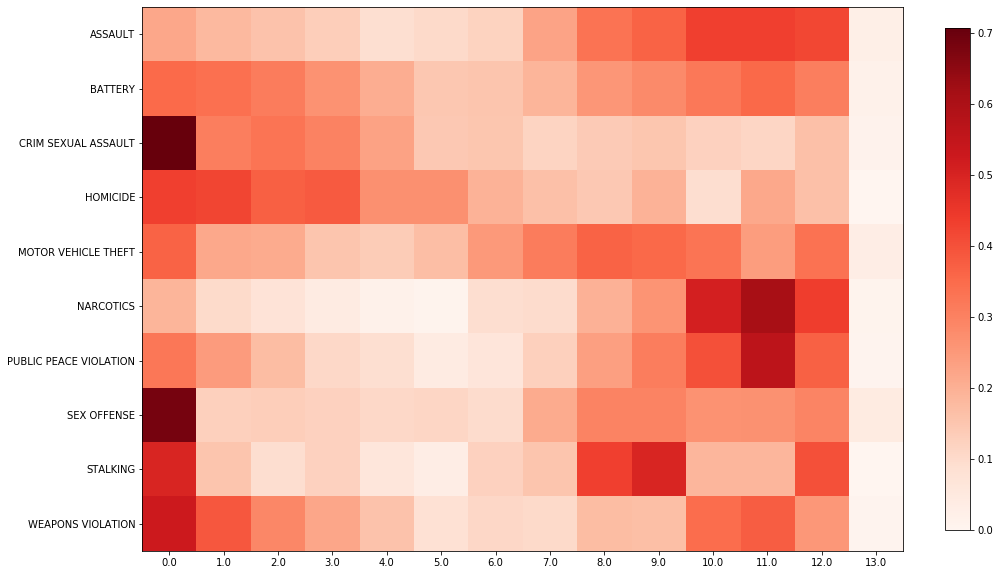

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C5, crime_by_hour_C5.columns)

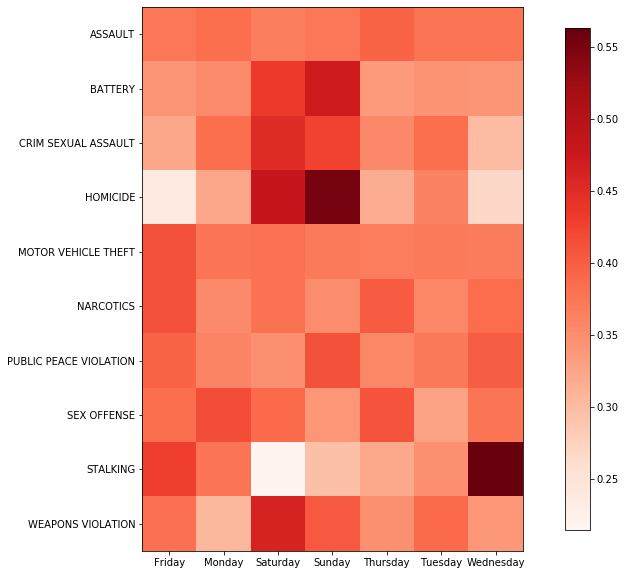

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C5, crime_by_week_C5.columns)

### Cluster 6

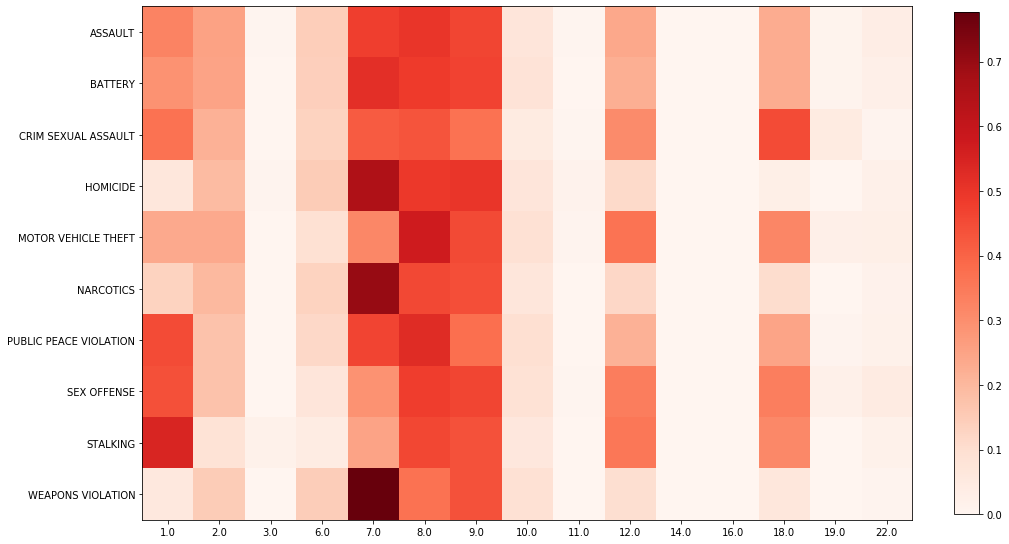

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C6 = data0_Cluster_6.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C6[crime_by_district_C6.columns] = normalize.fit_transform(crime_by_district_C6)

crime_by_hour_C6 = data0_Cluster_6.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C6[crime_by_hour_C6.columns] = normalize.fit_transform(crime_by_hour_C6)

crime_by_week_C6 = data0_Cluster_6.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C6[crime_by_week_C6.columns] = normalize.fit_transform(crime_by_week_C6)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C6, crime_by_district_C6.columns)
plt.show()

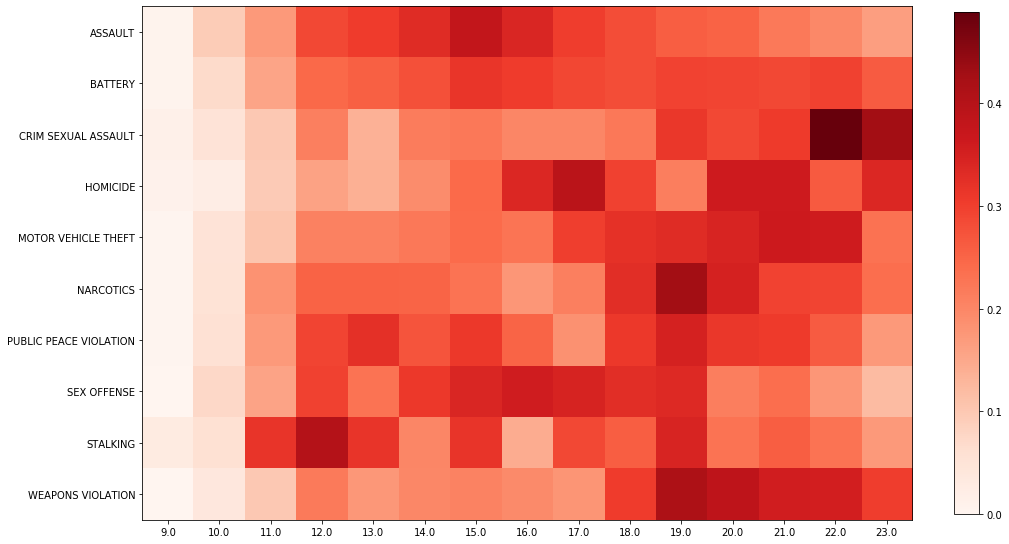

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C6, crime_by_hour_C6.columns)

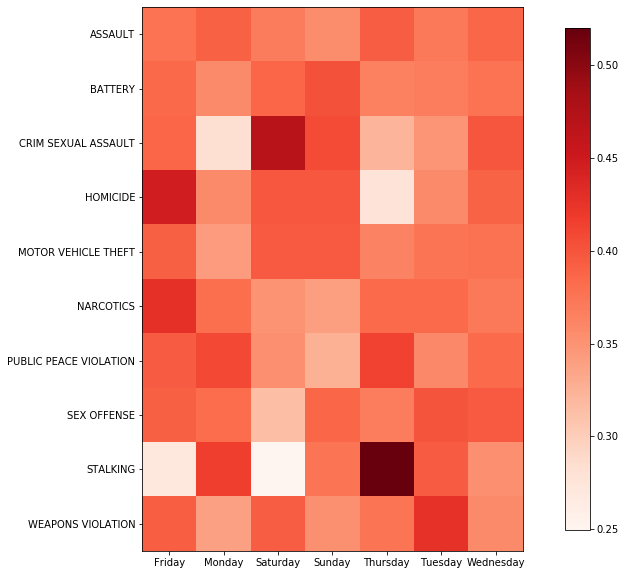

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C6, crime_by_week_C6.columns)

### Cluster 7

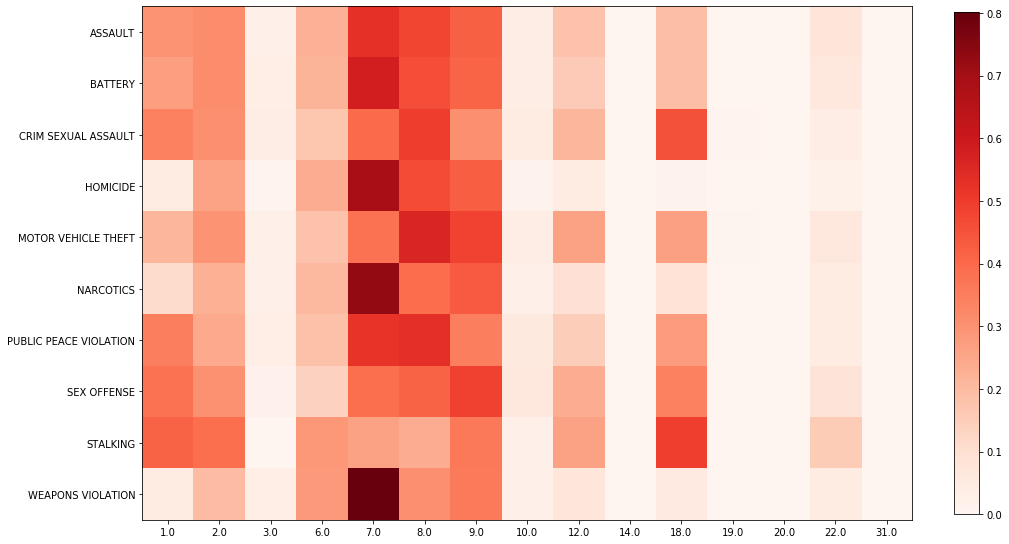

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C7 = data0_Cluster_7.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C7[crime_by_district_C7.columns] = normalize.fit_transform(crime_by_district_C7)

crime_by_hour_C7 = data0_Cluster_7.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C7[crime_by_hour_C7.columns] = normalize.fit_transform(crime_by_hour_C7)

crime_by_week_C7 = data0_Cluster_7.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C7[crime_by_week_C7.columns] = normalize.fit_transform(crime_by_week_C7)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C7, crime_by_district_C7.columns)
plt.show()

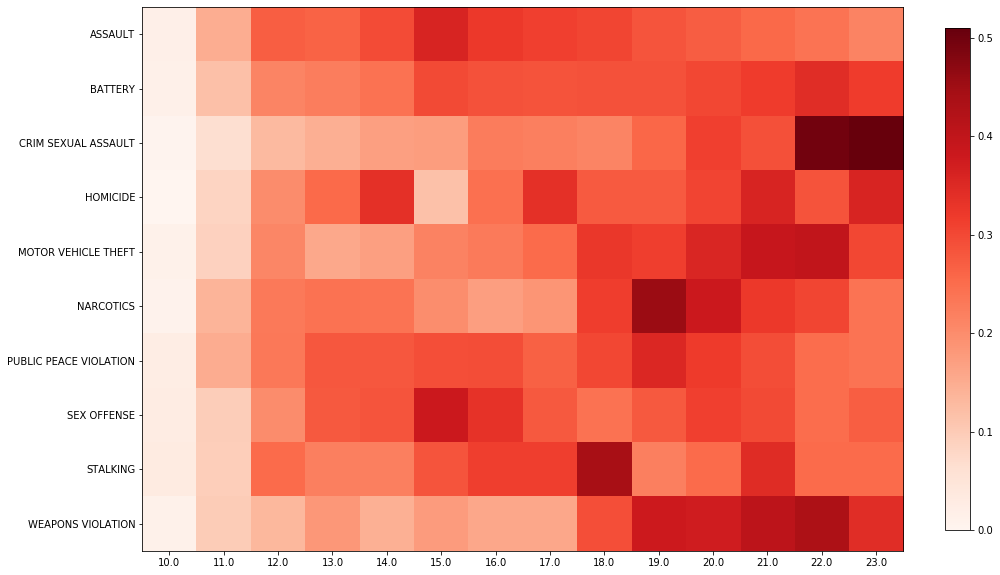

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C7, crime_by_hour_C7.columns)

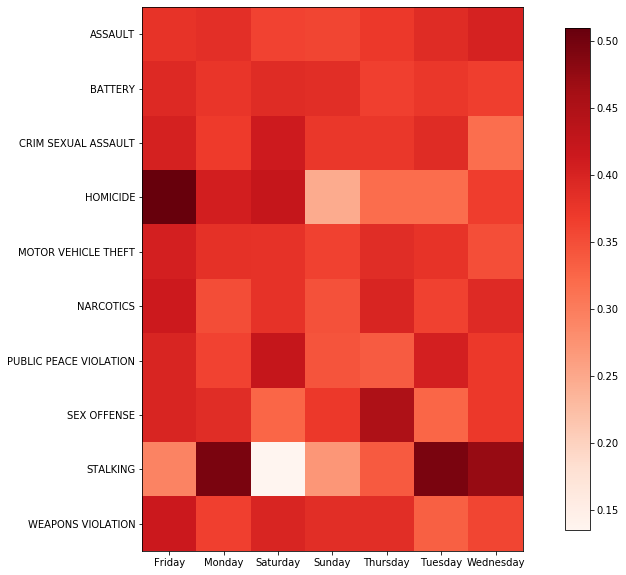

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C7, crime_by_week_C7.columns)

### Cluster 8

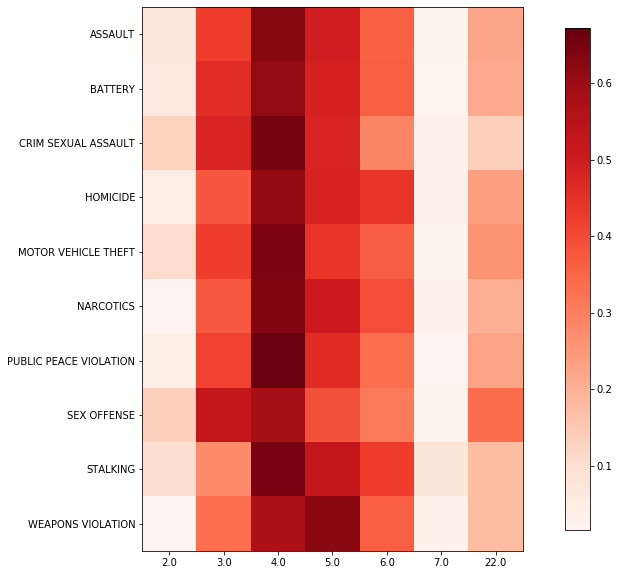

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C8 = data0_Cluster_8.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C8[crime_by_district_C8.columns] = normalize.fit_transform(crime_by_district_C8)

crime_by_hour_C8 = data0_Cluster_8.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C8[crime_by_hour_C8.columns] = normalize.fit_transform(crime_by_hour_C8)

crime_by_week_C8 = data0_Cluster_8.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C8[crime_by_week_C8.columns] = normalize.fit_transform(crime_by_week_C8)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C8, crime_by_district_C8.columns)
plt.show()

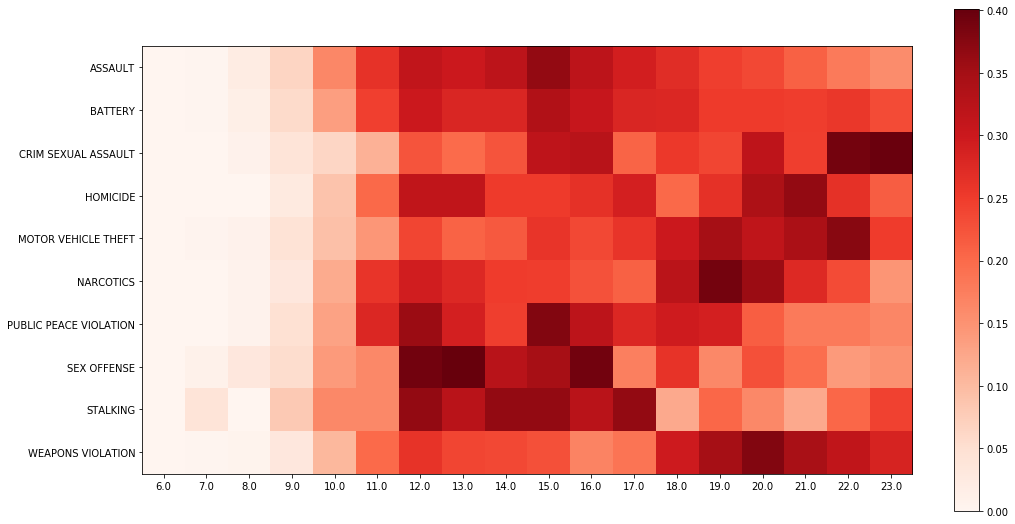

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C8, crime_by_hour_C8.columns)

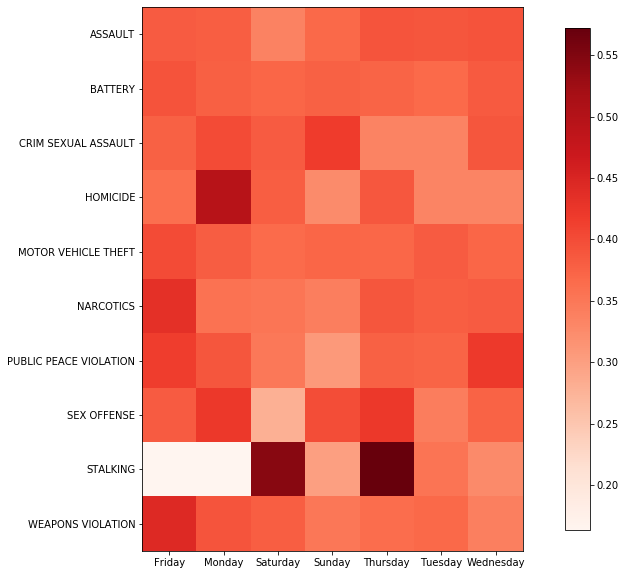

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C8, crime_by_week_C8.columns)

### Cluster 9

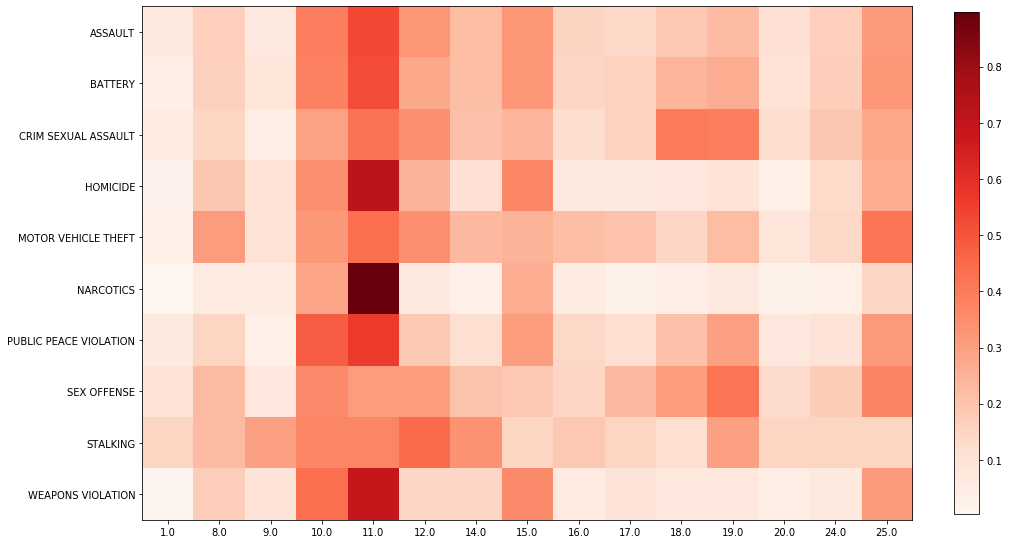

In [0]:
normalize = preprocessing.Normalizer()
crime_by_district_C9 = data0_Cluster_9.pivot_table(values='ID', index='Crime', columns=['District'], aggfunc=np.size).fillna(0)
crime_by_district_C9[crime_by_district_C9.columns] = normalize.fit_transform(crime_by_district_C9)

crime_by_hour_C9 = data0_Cluster_9.pivot_table(values='ID', index='Crime', columns=['Hours'], aggfunc=np.size).fillna(0)
crime_by_hour_C9[crime_by_hour_C9.columns] = normalize.fit_transform(crime_by_hour_C9)

crime_by_week_C9 = data0_Cluster_9.pivot_table(values='ID', index='Crime', columns=['Weekday'], aggfunc=np.size).fillna(0)
crime_by_week_C9[crime_by_week_C9.columns] = normalize.fit_transform(crime_by_week_C9)

plt.figure(figsize=(15,10))
plot_hmap(crime_by_district_C9, crime_by_district_C9.columns)
plt.show()

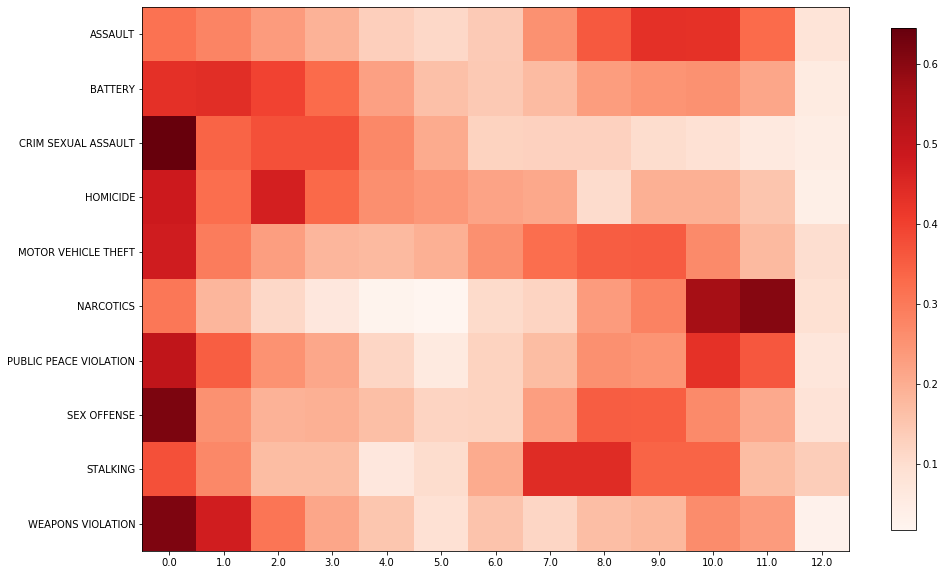

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_hour_C9, crime_by_hour_C9.columns)

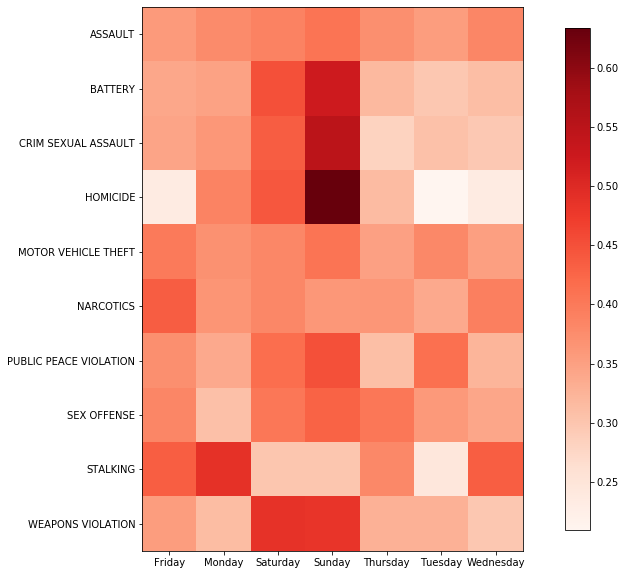

In [0]:
plt.figure(figsize=(15,10))
plot_hmap(crime_by_week_C9, crime_by_week_C9.columns)

# Predição

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
lencoder = preprocessing.LabelEncoder()

data_predict = data_main_crimes.loc[:, ['District','Ward','IUCR'] ]

def transformIUCR( d ):
  if( str.isdigit(d) == True ):
    return int(d)
  return int( d[:-1] )

data_predict['IUCR'] = [ transformIUCR(d) for d in data_predict['IUCR'] ]

scaler = preprocessing.StandardScaler()

data_predict[data_predict.columns] = scaler.fit_transform(data_predict)

data_predict['Week Number'] = sub_data0.loc[:,'Week Number']
data_predict['Seconds'] = sub_data0.loc[:,'Seconds']
data_predict['Cluster'] = sub_data0.loc[:,'Cluster']

data_predict['Weekend'] = data_main_crimes.loc[:,'Weekend']
data_predict['Domestic'] = data_main_crimes.loc[:,'Domestic']
data_predict['Arrest'] = data_main_crimes.loc[:,'Arrest']

data_predict.head()


District      Ward      IUCR  ...  Weekend  Domestic  Arrest
47 -0.279532 -0.151725 -0.828406  ...    False      True   False
54 -0.430572 -0.618468 -0.828406  ...    False      True   False
56 -0.430572 -0.462887  1.344434  ...    False     False   False
62  0.626708  0.159436  0.251307  ...    False     False   False
63 -0.128492  0.159436  0.251307  ...    False     False   False

[5 rows x 9 columns]

In [0]:
X = data_predict.iloc[:,:-1]

Y = data_predict['Arrest']

( trainData, testData, trainLabels, testLabels ) = train_test_split( X, Y, test_size=0.1, random_state=40, stratify=Y )

In [0]:
gnb = GaussianNB()

gnb.fit(trainData, trainLabels)

predLabels = gnb.predict(testData)

In [0]:
from sklearn import metrics
metrics.accuracy_score(testLabels,predLabels)

0.7949144064925217